In [74]:
# In [1]
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [75]:
# In [2]
sns.set_palette("deep") 

os.chdir('/mnt/d/code/ChimeraBenchmark')

dir_pattern = "benchmark_results_*_0.7threshold"
all_dirs = sorted(glob.glob(dir_pattern))

all_csv_files = []
for d in all_dirs:
    csv_pattern = os.path.join(d, "benchmark_report_*_threshold_0.7.csv")
    found_csv = glob.glob(csv_pattern)
    all_csv_files.extend(found_csv)

print("找到的 CSV 文件数量：", len(all_csv_files))

df_list = []
for csv_file in all_csv_files:
    temp_df = pd.read_csv(csv_file)
    
    folder_name = os.path.basename(os.path.dirname(csv_file))
    core_name = folder_name.replace("benchmark_results_", "").replace("_0.7threshold", "")
    
    if "completeONE" in csv_file:
        db_type = "completeONE"
    else:
        db_type = "complete"
    
    if "_completeONE" in core_name:
        data_type = core_name.replace("_completeONE", "")
    else:
        data_type = core_name.replace("_complete", "")
    
    temp_df["DataType_Folder"] = data_type
    temp_df["DBType_Folder"]   = db_type
    
    df_list.append(temp_df)

df_all = pd.concat(df_list, ignore_index=True)
print("合并后的 DataFrame 大小：", df_all.shape)
df_all.head()


找到的 CSV 文件数量： 10
合并后的 DataFrame 大小： (7416, 8)


,Software,Sequence_File,ReturnCode,Runtime_seconds,PeakMemory_MB,ResultFile,DataType_Folder,DBType_Folder
0,Taxor,/mnt/sdb/mnt_sda/tianqinzhong/project/dataset/...,0,35,12776.23828,./benchmark_results/results/Taxor_sample0_anon...,marlong,completeONE
1,Taxor,/mnt/sdb/mnt_sda/tianqinzhong/project/dataset/...,0,41,12777.81250,./benchmark_results/results/Taxor_sample1_anon...,marlong,completeONE
2,Taxor,/mnt/sdb/mnt_sda/tianqinzhong/project/dataset/...,0,39,12766.03125,./benchmark_results/results/Taxor_sample2_anon...,marlong,completeONE
3,Taxor,/mnt/sdb/mnt_sda/tianqinzhong/project/dataset/...,0,43,12767.87891,./benchmark_results/results/Taxor_sample3_anon...,marlong,completeONE
4,Taxor,/mnt/sdb/mnt_sda/tianqinzhong/project/dataset/...,0,38,12761.83984,./benchmark_results/results/Taxor_sample4_anon...,marlong,completeONE


In [76]:
# In [3]
runtime_col = "Runtime_seconds"
memory_col  = "PeakMemory_MB"

# (1) 去掉 bracken
df_all = df_all[df_all["Software"].str.lower() != "bracken"].copy()

# (2) 聚合
df_grouped = df_all.groupby(
    ["Software","DataType_Folder","DBType_Folder"],
    as_index=False
).agg({
    runtime_col: "mean",  # 或 "sum"
    memory_col:  "mean"   # 或 "sum"
})

# (3) 计算每个软件的 total
df_tot = df_grouped.groupby("Software", as_index=False).agg({
    runtime_col: "sum",   # 或 "mean"
    memory_col:  "sum"
})
df_tot["DataType_Folder"] = "ALL"
df_tot["DBType_Folder"]   = "ALL"

df_temp = pd.concat([df_grouped, df_tot], ignore_index=True)

# (4) 秒->分钟, MB->GB
df_temp[runtime_col] = df_temp[runtime_col] / 60.0    # seconds -> minutes
df_temp[memory_col]  = df_temp[memory_col] / 1024.0  # MB -> GB

# (5) Combo & Pretty
def make_combo(row):
    if row["DataType_Folder"]=="ALL" and row["DBType_Folder"]=="ALL":
        return "Total"
    else:
        return f"{row['DataType_Folder']}_{row['DBType_Folder']}"

df_temp["Combo"] = df_temp.apply(make_combo, axis=1)

combo_map = {
    "marlong_complete":         "CAMI II Marine (long read) - complete",
    "marlong_completeONE":      "CAMI II Marine (long read) - completeONE",
    "marshort_complete":        "CAMI II Marine (short read) - complete",
    "marshort_completeONE":     "CAMI II Marine (short read) - completeONE",
    "mouselong_complete":       "CAMI II Toy Mouse Gut (long read) - complete",
    "mouselong_completeONE":    "CAMI II Toy Mouse Gut (long read) - completeONE",
    "mouseshort_complete":      "CAMI II Toy Mouse Gut (short read) - complete",
    "mouseshort_completeONE":   "CAMI II Toy Mouse Gut (short read) - completeONE",
    "simulated_complete":       "Simulated Dataset - complete",
    "simulated_completeONE":    "Simulated Dataset - completeONE",
    "Total":                    "Total"
}
df_temp["Combo_Pretty"] = df_temp["Combo"].map(combo_map).fillna(df_temp["Combo"])

# (6) 长表 df_long
df_long = df_temp.rename(
    columns={
        runtime_col: "Runtime_min",
        memory_col:  "Memory_GB"
    }
)[ ["Software","Combo","Combo_Pretty","Runtime_min","Memory_GB"] ]

df_long.head(15)


,Software,Combo,Combo_Pretty,Runtime_min,Memory_GB
0,Chimera,marlong_complete,CAMI II Marine (long read) - complete,1.270000,31.429435
1,Chimera,marlong_completeONE,CAMI II Marine (long read) - completeONE,1.898333,25.147954
2,Chimera,marshort_complete,CAMI II Marine (short read) - complete,3.230000,31.815869
3,Chimera,marshort_completeONE,CAMI II Marine (short read) - completeONE,3.443333,25.507099
4,Chimera,mouselong_complete,CAMI II Toy Mouse Gut (long read) - complete,0.683333,30.440316
5,Chimera,mouselong_completeONE,CAMI II Toy Mouse Gut (long read) - completeONE,0.990432,24.147373
6,Chimera,mouseshort_complete,CAMI II Toy Mouse Gut (short read) - complete,0.986458,30.462257
7,Chimera,mouseshort_completeONE,CAMI II Toy Mouse Gut (short read) - completeONE,1.176042,24.165749
8,Chimera,simulated_complete,Simulated Dataset - complete,0.791875,29.997707
9,Chimera,simulated_completeONE,Simulated Dataset - completeONE,0.837118,23.707284


In [77]:
# In [4]
df_total_only = df_long[df_long["Combo"]=="Total"].copy()

# (1) Runtime 排序 (descending)
df_total_runtime = df_total_only.sort_values(by="Runtime_min", ascending=False)
runtime_software_order = df_total_runtime["Software"].tolist()

# (2) Memory 排序 (descending)
df_total_memory = df_total_only.sort_values(by="Memory_GB", ascending=False)
memory_software_order = df_total_memory["Software"].tolist()

print("Runtime子图软件顺序:", runtime_software_order)
print("Memory子图软件顺序:", memory_software_order)


Runtime子图软件顺序: ['Ganon', 'Kraken2', 'Chimera', 'Ganon2', 'Taxor']
Memory子图软件顺序: ['Ganon', 'Kraken2', 'Ganon2', 'Chimera', 'Taxor']


In [78]:
# In [5]
def plot_overshadow_bars_horizontal(
    df_long,
    ax,
    measure_col,      # "Runtime_min" or "Memory_GB"
    software_order,   # 每个子图按 total 值排好(大->小)的软件列表
    title,
    x_label
):
    """
    df_long: (Software, Combo, Combo_Pretty, Runtime_min, Memory_GB)
    measure_col: 要画的列 (Runtime_min / Memory_GB)
    software_order: 外部排序好的软件列表(大->小)
    title, x_label: 子图标题与 X轴标签
    
    - 先画总柱 "Total" (不进图例), 并在条上标数值
    - 再对 combos(非 Total) 按 measure 从大到小画 barh
      不同 combo 用 label=combo_pretty
      => 返回 handles dict, 后面 ax.legend
    """
    df_filtered = df_long.dropna(subset=[measure_col])
    df_total = df_filtered[df_filtered["Combo"]=="Total"].set_index("Software")

    # 小柱高度
    height_small = 0.7/10  # 10 combos => total=0.5
    height_total = 0.7

    legend_dict = {}

    for i, sw in enumerate(software_order):
        y_center = i
        # 该软件 total
        val_total = 0
        if sw in df_total.index:
            val_total = df_total.loc[sw, measure_col]
        
        # --- 1) 画 total (灰色大条)
        total_bar = ax.barh(
            y=y_center,
            width=val_total,
            height=height_total,
            color="lightgray",
            edgecolor="gray",
            linewidth=1,
            label="Total"
        )
        
        legend_dict["Total"] = total_bar

        # 在 total 条上标数值
        ax.bar_label(
            total_bar,
            fmt="%.2f",
            label_type="center",
            color="black",
            fontsize=8
        )
        
        # --- 2) 该软件的其他 combos, 从大到小
        df_sw = df_filtered[
            (df_filtered["Software"]==sw) & (df_filtered["Combo"]!="Total")
        ].copy()
        df_sw.sort_values(by=measure_col, ascending=False, inplace=True)  # 从大到小

        combos_count = len(df_sw)
        if combos_count>1:
            offset_indices = np.linspace(-(combos_count-1)/2, (combos_count-1)/2, combos_count)
        else:
            offset_indices = [0]

        for j, (idx_row, row) in enumerate(df_sw.iterrows()):
            offset = offset_indices[j]*height_small
            y_bar = y_center + offset
            bar_val = row[measure_col]
            combo_pretty = row["Combo_Pretty"]

            small_bar = ax.barh(
                y=y_bar,
                width=bar_val,
                height=height_small,
                label=combo_pretty  # 进入图例
            )
            
            if combo_pretty not in legend_dict:
                legend_dict[combo_pretty] = small_bar

    # 设置 Y 轴
    ax.set_yticks(np.arange(len(software_order)))
    ax.set_yticklabels(software_order)
    ax.invert_yaxis()
    ax.set_xlabel(x_label)
    ax.set_title(title)

    return legend_dict


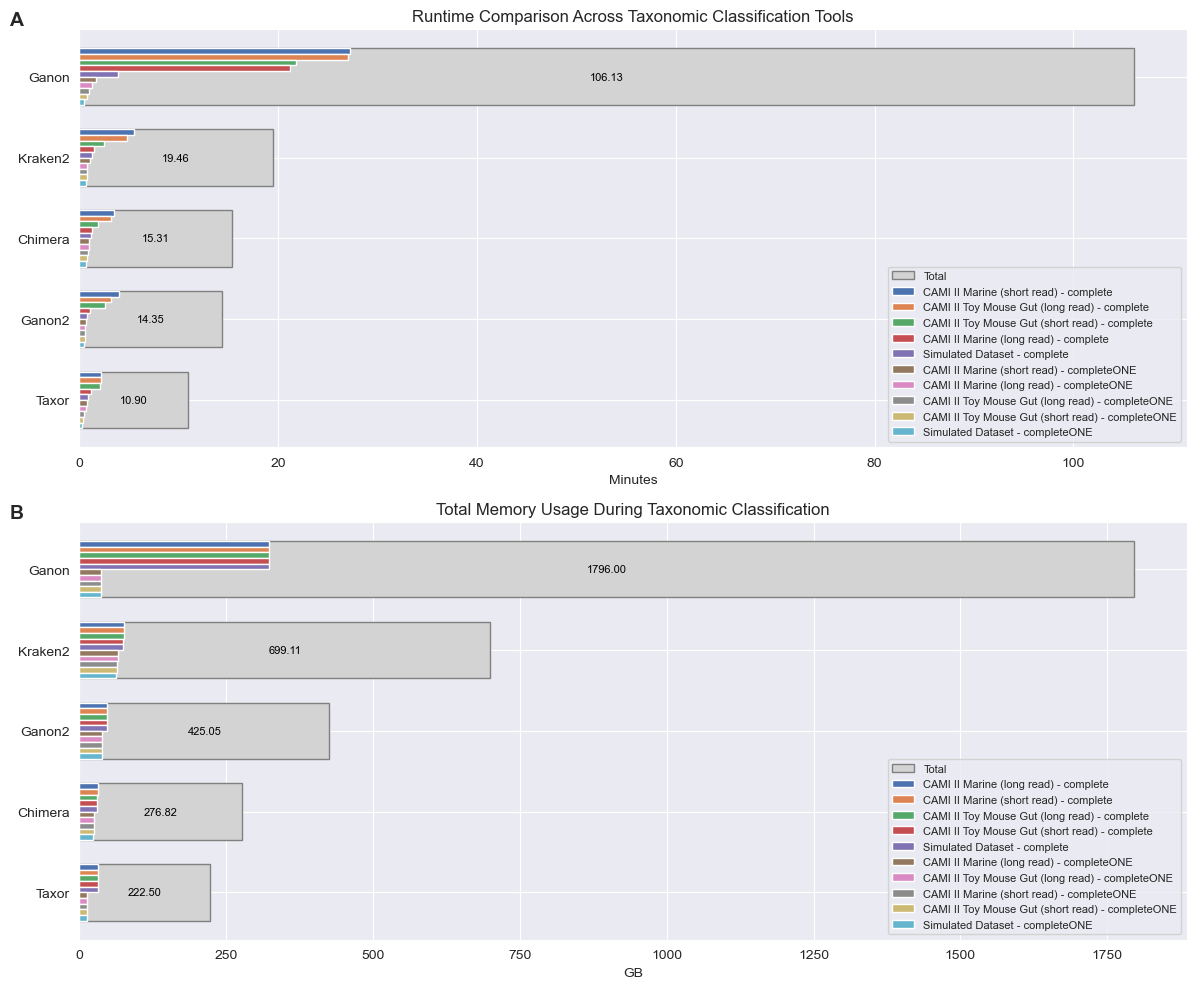

In [79]:
# In [6]
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)
# ============== (1) Runtime 子图 ==============
handles_runtime = plot_overshadow_bars_horizontal(
    df_long=df_long,
    ax=axes[0],
    measure_col="Runtime_min",
    software_order=runtime_software_order,  # 大->小
    title="Runtime (minutes)",
    x_label="Minutes"
)

# 取 label, handle
labels_rt, handles_rt = [], []
for label, handle in handles_runtime.items():
    labels_rt.append(label)
    handles_rt.append(handle[0])  # barh返回的是一个 container list

# 设置图例，loc="lower right" 使其在图内右下角
axes[0].legend(
    handles_rt,
    labels_rt,
    loc="lower right",
    fontsize=8
)


# ============== (2) Memory 子图 ==============
handles_memory = plot_overshadow_bars_horizontal(
    df_long=df_long,
    ax=axes[1],
    measure_col="Memory_GB",
    software_order=memory_software_order,  # 大->小
    title="Peak Memory (GB)",
    x_label="GB"
)

labels_mem, handles_mem = [], []
for label, handle in handles_memory.items():
    labels_mem.append(label)
    handles_mem.append(handle[0])

axes[1].legend(
    handles_mem,
    labels_mem,
    loc="lower right",
    fontsize=8
)

# 对第一个子图
axes[0].text(
    x=-0.05, y=1,          # 相对坐标，可根据需要微调
    s="A",                   # 显示字母 A
    transform=axes[0].transAxes,  # 使用子图自身的坐标系
    fontsize=14, fontweight="bold",
    ha="right", va="bottom"  # 对齐方式
)
axes[0].set_title("Runtime Comparison Across Taxonomic Classification Tools", fontsize=12)

# 对第二个子图
axes[1].text(
    x=-0.05, y=1, 
    s="B",
    transform=axes[1].transAxes,
    fontsize=14, fontweight="bold",
    ha="right", va="bottom"
)
axes[1].set_title("Total Memory Usage During Taxonomic Classification", fontsize=12)

plt.tight_layout()
plt.show()


In [80]:
# In [7]
## 保存图片为svg和pdf格式
fig.savefig("runtime_memory_comparison.svg", format="svg", bbox_inches="tight")
fig.savefig("runtime_memory_comparison.pdf", format="pdf", bbox_inches="tight")